# Data Preprocessing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("data/gidamps_music_combined_fatigue_df_111224_with_cmh.csv")

CUCQ5 is the fatigue question

In [3]:
def map_fatigue_outcome(score):
    if score >= 10:
        return "fatigue"
    else:
        return "no_fatigue"


df["fatigue_outcome"] = df["cucq_5"].apply(map_fatigue_outcome)

## Feature Engineering

4 features are created here:
- disease_duration_weeks = cucq_date - date_of_diagnosis
- season based on cucq_date if month is 12-2 winter, 3-5 spring, 6-8 summer, 9-11 autumn
- ada_drug_level_present
- ifx_drug_level_present

In [4]:
df["cucq_date"] = pd.to_datetime(df["cucq_date"])
df["date_of_diagnosis"] = pd.to_datetime(df["date_of_diagnosis"])

In [5]:
df["disease_duration_weeks"] = (df["cucq_date"] - df["date_of_diagnosis"]).dt.days / 7

In [6]:
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return "winter"
    elif month in [3, 4, 5]:
        return "spring"
    elif month in [6, 7, 8]:
        return "summer"
    elif month in [9,10,11]:
        return "autumn"
    else:
        return "no_data"


df["season"] = df["cucq_date"].apply(get_season)

In [7]:
df["diagnosis_year"] = df["date_of_diagnosis"].dt.year

In [8]:
# Create these 2 columns so we can zero out the drug level column where data is not available
df['ada_drug_level_present'] = df['ada_drug_level'].apply(lambda x: 0 if pd.isnull(x) else 1)
df['ifx_drug_level_present'] = df['ifx_drug_level'].apply(lambda x: 0 if pd.isnull(x) else 1)

## Dealing with missing data

### Visualize missing data

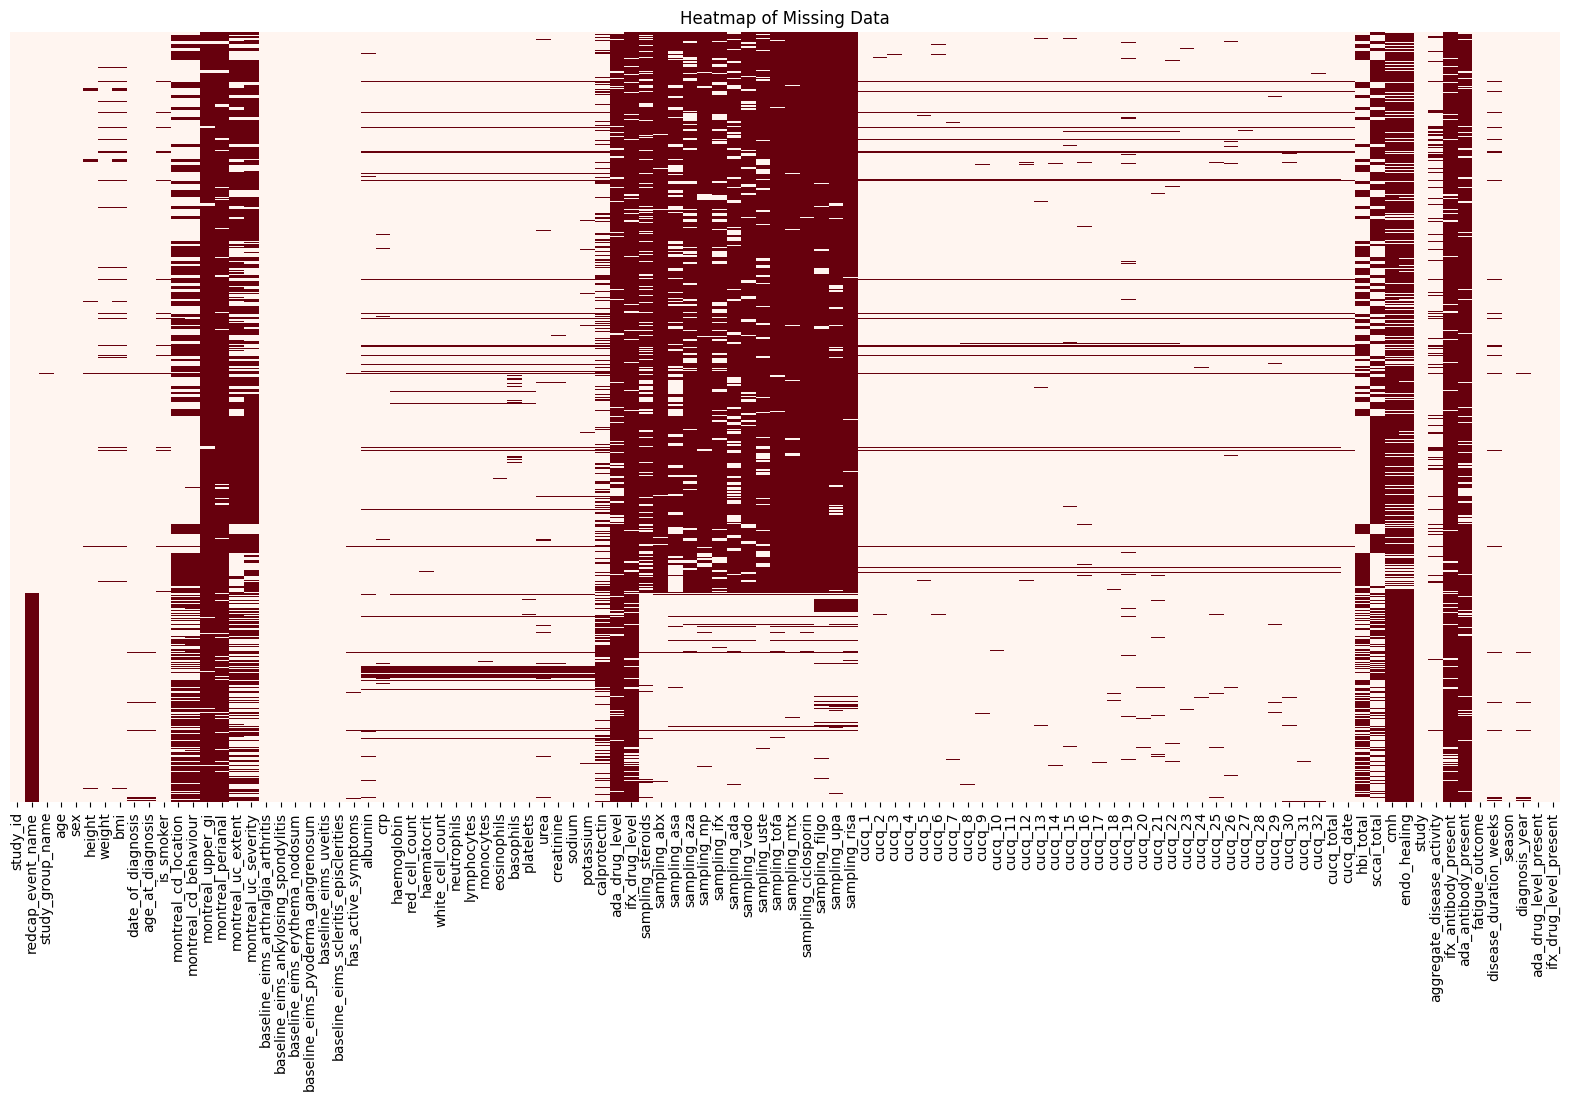

In [9]:
plt.figure(figsize=(20, 10))
sns.heatmap(df.isnull(), cbar=False, cmap="Reds", yticklabels=False)
plt.title("Heatmap of Missing Data")
plt.show()

### Missing Data Imputation and Removal of Unnecessary Columns

In [10]:
columns_to_fill_with_zero = [
    "montreal_perianal",
    "montreal_upper_gi",
    "baseline_eims_arthralgia_arthritis",
    "baseline_eims_ankylosing_spondylitis",
    "baseline_eims_erythema_nodosum",
    "baseline_eims_pyoderma_gangrenosum",
    "baseline_eims_uveitis",
    "baseline_eims_scleritis_episclerities",
    "has_active_symptoms",
    "sampling_steroids",
    "sampling_abx",
    "sampling_asa",
    "sampling_aza",
    "sampling_mp",
    "sampling_ifx",
    "sampling_ada",
    "sampling_vedo",
    "sampling_uste",
    "sampling_tofa",
    "sampling_mtx",
    "sampling_ciclosporin",
    "sampling_filgo",
    "sampling_upa",
    "sampling_risa",
    "ifx_antibody_present",
    "ada_antibody_present",
    "ada_drug_level",
    "ifx_drug_level",
]

columns_to_fill_with_median = [
    "has_active_symptoms",
    "height",
    "weight",
    "bmi",
    "age_at_diagnosis",
    "albumin",
    "crp",
    "haemoglobin",
    "red_cell_count",
    "haematocrit",
    "white_cell_count",
    "neutrophils",
    "lymphocytes",
    "monocytes",
    "eosinophils",
    "basophils",
    "platelets",
    "urea",
    "creatinine",
    "sodium",
    "potassium",
    "calprotectin",
    "disease_duration_weeks",
    "diagnosis_year"
]

for column in columns_to_fill_with_zero:
    df[column] = df[column].fillna(0)


for column in columns_to_fill_with_median:
    df[column] = df[column].fillna(df[column].median())

In [11]:
columns_not_used_in_model_building = [
    "cucq_1",
    "cucq_2",
    "cucq_3",
    "cucq_4",
    "cucq_5",
    "cucq_6",
    "cucq_7",
    "cucq_8",
    "cucq_9",
    "cucq_10",
    "cucq_11",
    "cucq_12",
    "cucq_13",
    "cucq_14",
    "cucq_15",
    "cucq_16",
    "cucq_17",
    "cucq_18",
    "cucq_19",
    "cucq_20",
    "cucq_21",
    "cucq_22",
    "cucq_23",
    "cucq_24",
    "cucq_25",
    "cucq_26",
    "cucq_27",
    "cucq_28",
    "cucq_29",
    "cucq_30",
    "cucq_31",
    "cucq_32",
    "cucq_total",
    "date_of_diagnosis",
    "cucq_date",
    "cmh",
    "endo_healing",
    "hbi_total",
    "sccai_total"
]

df.drop(columns=columns_not_used_in_model_building, inplace=True)

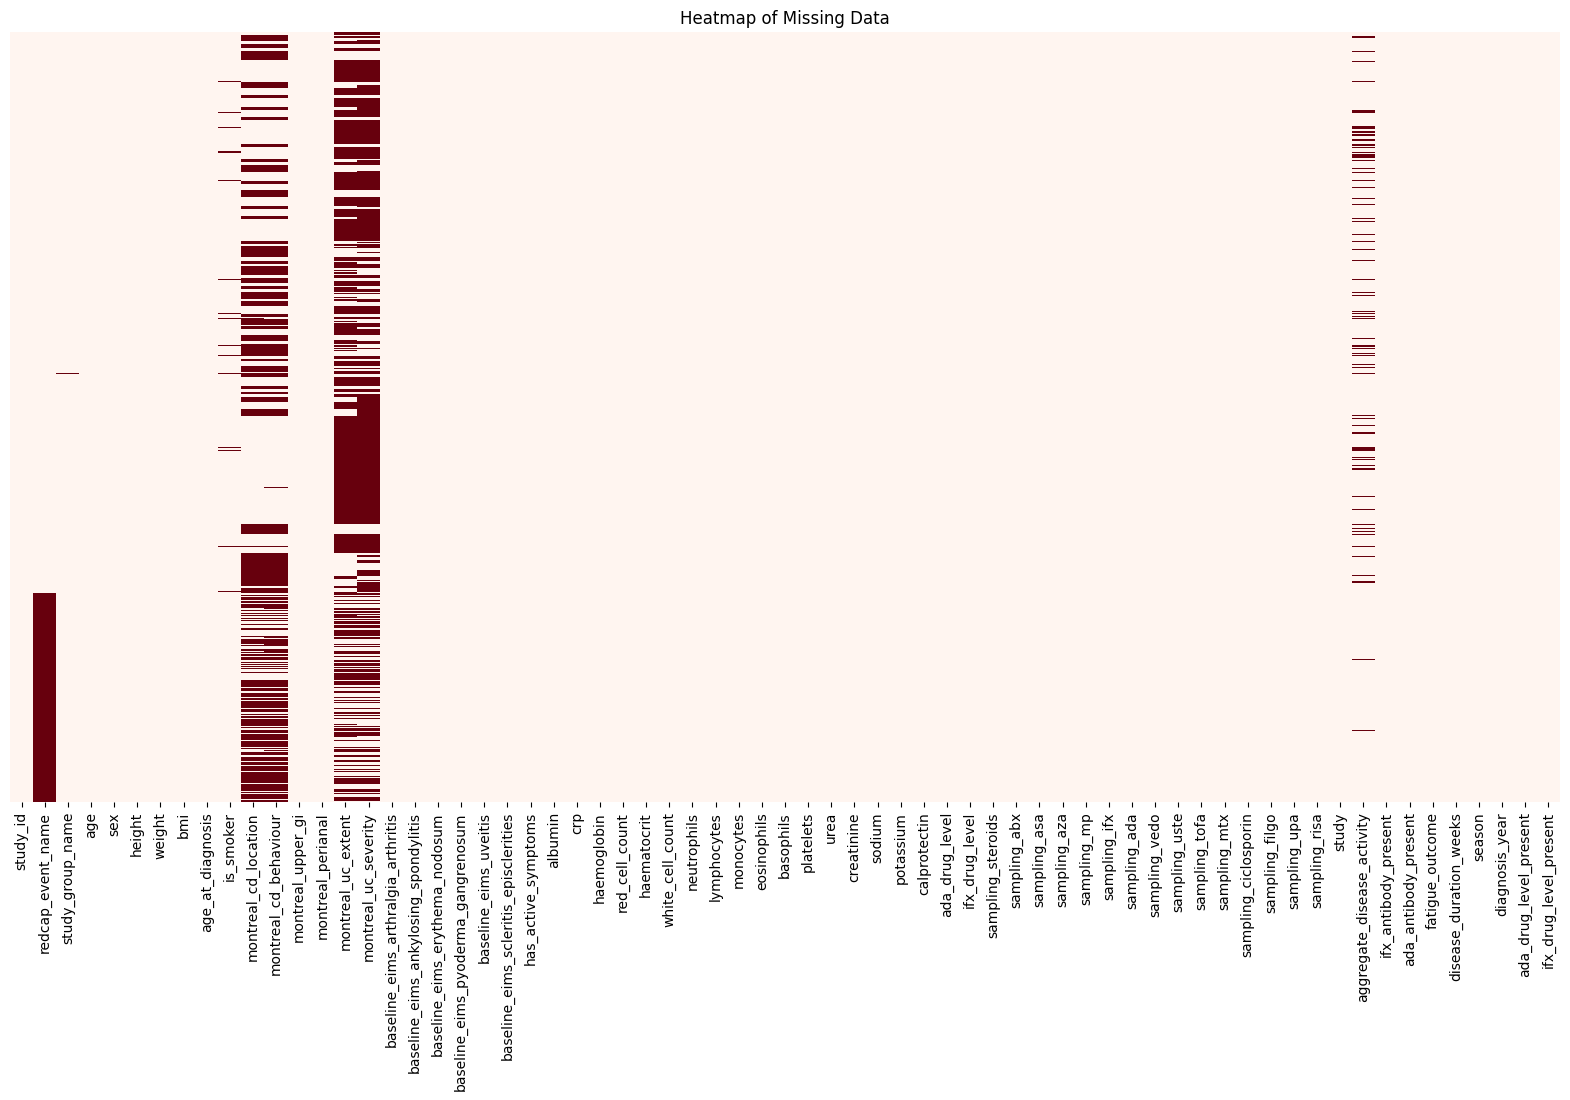

In [12]:
plt.figure(figsize=(20, 10))
sns.heatmap(df.isnull(), cbar=False, cmap="Reds", yticklabels=False)
plt.title("Heatmap of Missing Data")
plt.show()

In [13]:
# If you wish to analyse the dataframe in R, uncomment the line below.
# This is prior to one hot encoding and numerical feature scaling
# df.to_csv("working_data/all_ibd_R_analysis.csv", index=False)

# One Hot Encoding for ML

In [14]:
df['montreal_cd_location'] = df['montreal_cd_location'].replace('L3 Ileocoloni', 'L3 Ileocolonic')

In [15]:
df['montreal_cd_location'].value_counts()

montreal_cd_location
L2 Colonic        297
L3 Ileocolonic    266
L1 Ileal           97
Name: count, dtype: int64

In [16]:
categorical_features_for_one_hot_encoding = [
    "redcap_event_name",
    "study_group_name",
    "montreal_cd_location",
    "montreal_cd_behaviour",
    "montreal_uc_extent",
    "montreal_uc_severity",
    "aggregate_disease_activity",
    "is_smoker",
    "season"
]

df = pd.get_dummies(df, columns=categorical_features_for_one_hot_encoding, dtype=int)

## Numerical Feature Scaling

Numerical feature scaling is performed in the ML notebooks to enable the testing of different scaling methods. We have tested a number of scaling methods and found that they did not make any significant differences to the final model.

We will export the current dataframe as an interim csv which enables visual inspection.

In [17]:
df.to_csv("working_data/all_ibd_ml_input.csv", index=False)